In [1]:
from IPython.display import Video, Image, HTML
import jax
import jax.numpy as jnp
import numpy as np
import scipy
import gzip
import pickle
import matplotlib
import matplotlib.pyplot as plt
from celluloid import Camera

##### Machine Learning and Applications - Neural Networks

### David Picard 
### École des Ponts ParisTech
### david.picard@enpc.fr

# Natural neuron


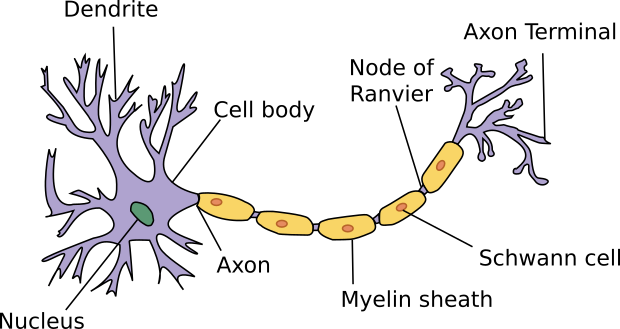

In [2]:
Image('Neuron.png', width=400)

# Artificial Neuron (McCulloch & Pitts)


$$ f(\mathbf{x}) = \varphi(\langle \mathbf{w}, \mathbf{x}\rangle + \theta ) $$

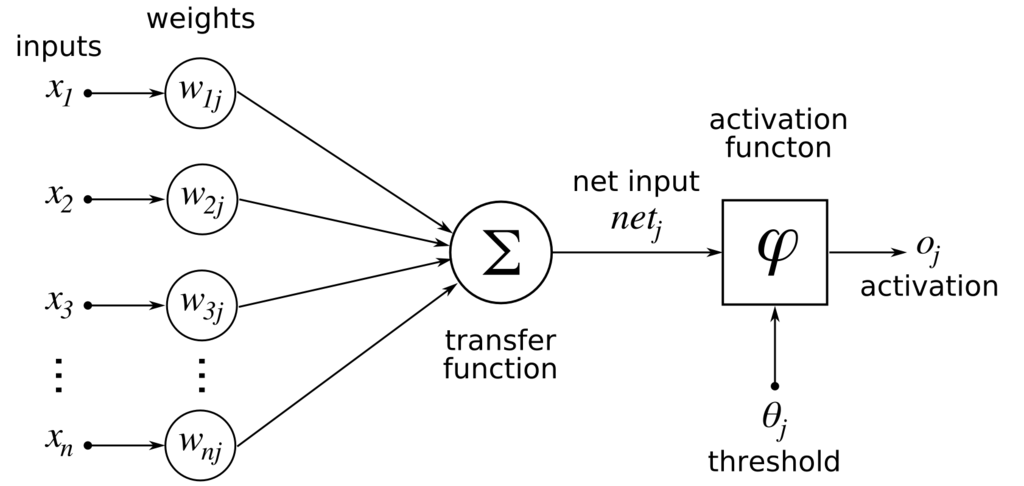

In [3]:
Image('a_neuron.png', width=400)

## Activation functions

Linear: $\varphi(x) = x$

Rectified Linear: $\varphi(x) = \max(0, x)$

Sigmoid: $\varphi(x) = \frac{1}{1+e^{-x}}$

Hyperbolic tangent $\varphi(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$

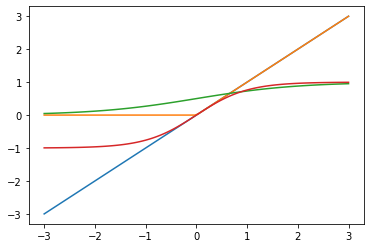

In [4]:
x = jnp.linspace(-3, 3, 100)
plt.plot(x, x, label='linear')
plt.plot(x, jax.nn.relu(x), label='relu')
plt.plot(x, jax.nn.sigmoid(x), label='sigmoid')
plt.plot(x, jnp.tanh(x), label='tanh')

## Training

Stochastic gradient descent on mini-batches from $\mathcal{A} = \{(\mathbf{x}, y)\}$, with loss function $l$

1. Draw random samples batch $B = \{(\mathbf{x}_i, y_i)\} \subset \mathcal{A}$
2. Compute gradient estimator 
$$\delta = \frac{1}{\vert B\vert}\sum_{(\mathbf{x}_i, y_i) \in B}\frac{\partial l(y_i, f(\mathbf{x}_i)}{\partial \mathbf{w}}$$
3. Apply gradient descent $\mathbf{w} \leftarrow \mathbf{w} - \eta \delta$

## Small example

5


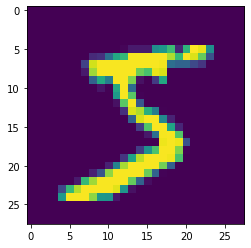

In [7]:
# Load the dataset
data = np.load('mnist.npz')
X = data['X_train']
y = data['y_train']
plt.imshow(X[0,:].reshape(28,28))
print(y[0])

### Binary cross-entropy loss

Using sigmoid activation, $f(\mathbf{x})$ is a probability


Minimize the cross-entropy (push output to either 0 or 1)
$$\mathcal{L} = - y \log f(\mathbf{x}) - (1-y) \log (1 - f(\mathbf{x})) $$

In [8]:
X = data['X_train_bin']
y = data['y_train_bin']

def func(w, b, x):
    return jax.nn.sigmoid(jnp.matmul(x, w) + b)

def xe(w, b, x, y):
    fx = func(w, b, x)
    return (-y*jnp.log(fx)-(1-y)*jnp.log(1-fx)).mean()

@jax.jit
def update(w, b, x, y):
    dw, db = jax.grad(xe, argnums=(0,1))(w, b, x, y)
    return w - 0.01*dw, b - 0.01*db

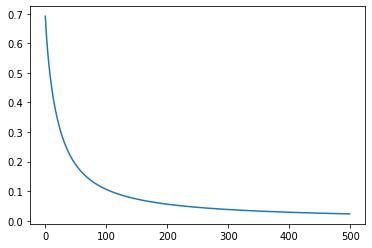

In [9]:
w = np.random.randn(784)/784
b = 0.

loss = []
for t in range(500):
    loss.append(xe(w, b, X, y))
    w, b = update(w, b, X, y)
plt.plot(loss)

In [10]:
def accuracy(y_pred, y_true):
    return (y_true==y_pred).mean()

y_pred = (func(w, b, X)>0.5)*1.
print('accuracy: {}'.format(accuracy(y_pred, y)))

accuracy: 1.0


### Non linearly separable problems

What about XOR?

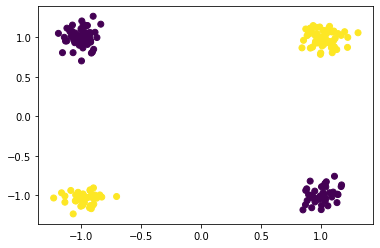

In [11]:
Xor = jnp.sign(np.random.randn(200, 2)) + 0.1*np.random.randn(200,2)
yor = 1.*((Xor[:,0]*Xor[:,1])>0)

plt.scatter(Xor[:,0], Xor[:,1], c=yor)

### Multiple layer


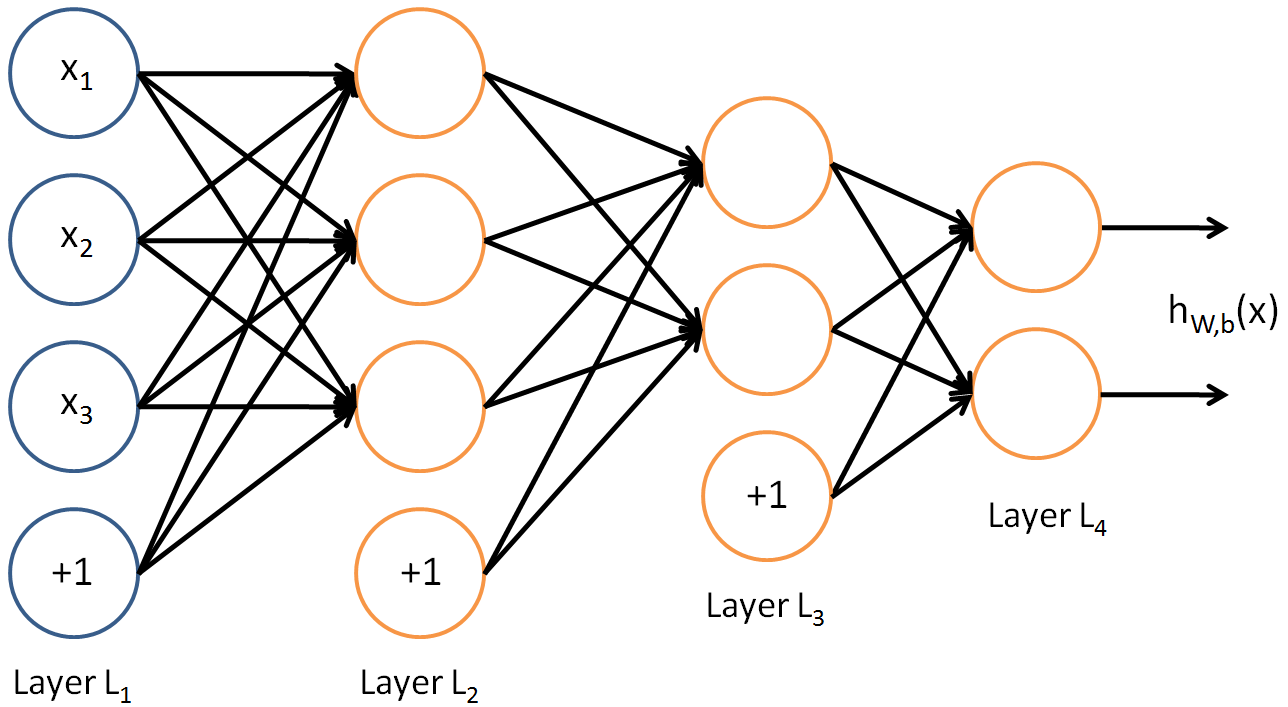

In [12]:
Image('mlp.png', width=400)

# Multiple Layer Perceptron

Set layer $i$ as the function that maps to $\mathbb{R}^d$ by stacking neurons

$$ f_i(\mathbf{x}) = [\sigma(\mathbf{W}_{ij}^\top\mathbf{x}+\theta_{ij})]_{j\leq d}$$

With
- $\mathbf{W}_{ij}, \theta_{ij}$ the weights and bias of neuron $j$ at layer $i$
- $\sigma$ the activation function

Create a network by composing $L$ layers

$$ F(\mathbf{x}) = f_L \circ \cdots \circ f_1(\mathbf{x}) $$

## XOR - Exercise

Find all weights for 1 hidden layer of width 2


Use Relu activation for the hidden layer and $\text{sign}$ for the output layer 

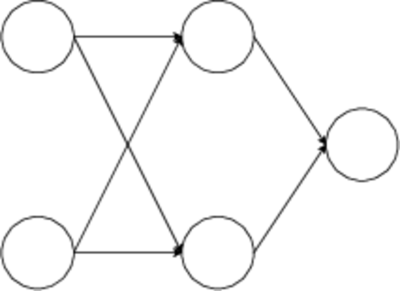

In [14]:
Image('2_xor.png', width=400)

## Training

ERM principle

$$ \min_{\{\mathbf{w}_i\}_i} \mathbb{E}_{(\mathbf{x},y)}\left[l(y, F(\mathbf{x}))\right] $$

Gradient descent

$$\forall i, \mathbf{w}_i \leftarrow \mathbf{w}_i - \eta \mathbb{E}_{(\mathbf{x},y)}\left[\frac{\partial l(y, F(\mathbf{x}))}{\partial\mathbf{w}_i}\right]$$

Monte-Carlo estimation with mini-batch strategy

$$ \mathbb{E}_{(\mathbf{x},y)}\left[\frac{\partial l(y, F(\mathbf{x}))}{\partial\mathbf{w}_i}\right] \approx \frac{1}{N}\sum_n \frac{\partial l(y_n, F(\mathbf{x}_n))}{\partial \mathbf{w}_i}$$

## Backpropagation


- Denote $\mathbf{x}_k = f_k \circ \cdots \circ f_1(\mathbf{x})$ the $k$-th intermediate output

- Denote $g_k(\mathbf{x}_k) = f_L \circ \cdots \circ f_{k+1}(\mathbf{x}_k)$ the output computed from $\mathbf{x}_k$

- Remark $\forall k, F_k = g_k(\sigma(\mathbf{w}_k^\top\mathbf{x}_{k-1} + \theta_k))$



Chain rule (Leibnitz notation)

$$\frac{\partial y}{\partial x} = \frac{\partial y}{\partial z}\frac{\partial z}{\partial x}$$



## Backpropagation

Single neuron chain



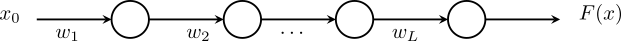

In [15]:
Image('neural_chain.png', width=600)

$$ \frac{\partial l(y, F(\mathbf{x}))}{\partial w_k} =  \frac{\partial l(y, F(\mathbf{x}))}{\partial F(\mathbf{x})} \frac{\partial F(\mathbf{x})}{\partial w_k}$$

\begin{align}
&= l'(y, F(\mathbf{x})) \frac{\partial \sigma(w_L\mathbf{x}_{L-1} + \theta_L)}{\partial w_k}\\
&= l'(y, F(\mathbf{x})) \sigma'(\mathbf{x}_L)\frac{\partial w_L\mathbf{x}_{L-1} + \theta_L}{\partial w_k}\\
&= l'(y, F(\mathbf{x})) \sigma'(\mathbf{x}_L)w_L\frac{\partial \mathbf{x}_{L-1}}{\partial w_k}
\end{align}

\begin{align}
\frac{\partial \mathbf{x}_{L-1}}{\partial w_k} &= \frac{\partial \sigma(w_{L-1}\mathbf{x}_{L-2} + \theta_{L-1})}{\partial w_k}\\
&=  \sigma'(\mathbf{x}_{L-1}) w_{L-1}\frac{\partial\mathbf{x}_{L-2}}{\partial w_k}
\end{align}

Recursion
\begin{align}
\frac{\partial\mathbf{x}_{k+t+1}}{\partial w_k} = \sigma'(\mathbf{x}_{k+t+1})w_{k+t+1}\frac{\partial \mathbf{x}_{k+t}}{\partial w_k} \\
\frac{\partial\mathbf{x}_{k}}{\partial w_k} = \sigma'(\mathbf{x}_k)\mathbf{x}_k
\end{align}


$$ \frac{\partial l(y, F(\mathbf{x}))}{\partial w_k} = l'(y, F(\mathbf{x})) \prod_{t=k+1}^L\sigma'(\mathbf{x}_t)w_t \sigma'(\mathbf{x}_k)\mathbf{x}_k $$




Note:

- if $w_t \ll 1$: vanishing gradients

- if $w_t \gg 1$: exploding gradients

- if $\sigma'(\cdot) \approx 0$: vanishing gradient (sigmoid, tanh, but not relu)



### Fully connected network

Recursion
\begin{align}
\delta_{L} &= l(y, F(\mathbf{x}))\sigma'(\mathbf{x}_L) \\
\delta_k &= \mathbf{w}_{k+1}(\sigma'(\mathbf{x}_{k+1}) \circ \delta_{k+1}) \\
\frac{\partial l(y, F(\mathbf{x}))}{\partial \mathbf{w}_k} &= \delta_k \circ \mathbf{x}_k
\end{align}

## Algorithm

Forward pass

- Compute and store $\forall k, \mathbf{x}_k$


Backward pass

- Compute $l'(y, F(\mathbf{x}))$

- $\forall k$, compute $\delta_k$

- Update $\mathbf{w}_k$ using $l'(y, F(\mathbf{x})), \delta_k, \mathbf{x}_k$


In practice, ML libraries have auto-grad features (pytorch, tensorflow, jax, etc) for certain operators that you compose to build $F$



## XOR with MLP

In [16]:
def l1(w1, b1, x):
    return jax.nn.relu(jnp.matmul(x, w1) + b1)

def func(w1, w2, b1, b2, x):
    x1 = l1(w1, b1, x)
    x2 = jax.nn.sigmoid(jnp.matmul(x1, w2) + b2)
    return x2

def xe(w1, w2, b1, b2, x, y):
    fx = func(w1, w2, b1, b2, x)
    return (-y*jnp.log(fx)-(1-y)*jnp.log(1-fx)).mean()

@jax.jit
def update(w1, w2, b1, b2, x, y, eta=0.1):
    dw1, dw2, db1, db2 = jax.grad(xe, argnums=(0,1,2,3))(w1, w2, b1, b2, x, y)
    return w1 - eta*dw1, w2 - eta*dw2, b1 - eta*db1, b2 - eta*db2

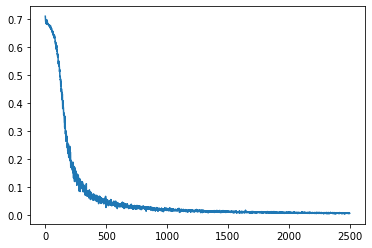

In [17]:
w1 = np.random.randn(2, 4)/10
w2 = np.random.randn(4)/10
b1 = np.random.randn(4)/10
b2 = np.random.randn(1)/10

loss = []
for t in range(2500):
    ind = np.random.choice(len(Xor), size=64, replace=False)
    loss.append(xe(w1, w2, b1, b2, Xor[ind, :], yor[ind]))
    w1, w2, b1, b2 = update(w1, w2, b1, b2, Xor[ind, :], yor[ind], eta=0.1)
plt.plot(loss)

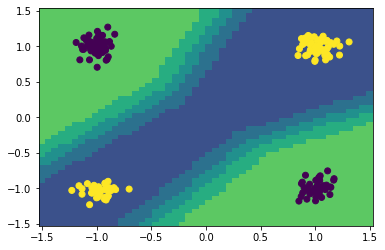

In [18]:
t = 50; tx = jnp.linspace(-1.5, 1.5, t)
xv, yv = jnp.meshgrid(tx, tx, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
xx = jnp.array([[xx, yy] for yy in yv for xx in xv])
y_pred = jnp.array(func(w1, w2, b1, b2, xx)).reshape(t, t)
cmap = plt.get_cmap('PiYG')
levels=jnp.linspace(-1.5, .5, 10)
norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
plt.pcolormesh(xv, yv, -y_pred, shading='nearest', norm=norm);
plt.scatter(Xor[:,0], Xor[:,1], c=yor)

### Intermediate layers

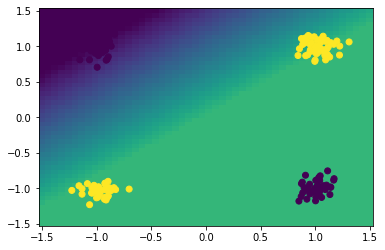

In [19]:
t = 50; tx = jnp.linspace(-1.5, 1.5, t);
xv, yv = jnp.meshgrid(tx, tx, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
xx = jnp.array([[xx, yy] for yy in yv for xx in xv])
y_pred = jnp.array(l1(w1, b1, xx)).reshape(t, t, 4)
cmap = plt.get_cmap('PiYG')
levels=jnp.linspace(-4., 2., 100)
norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
plt.pcolormesh(xv, yv, -y_pred[:,:,0], shading='nearest', norm=norm);
plt.scatter(Xor[:,0], Xor[:,1], c=yor)

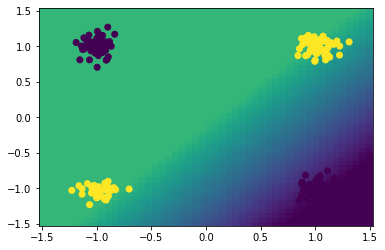

In [20]:
levels=jnp.linspace(-4., 2., 100)
norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
plt.pcolormesh(xv, yv, -y_pred[:,:,1], shading='nearest', norm=norm);
plt.scatter(Xor[:,0], Xor[:,1], c=yor)

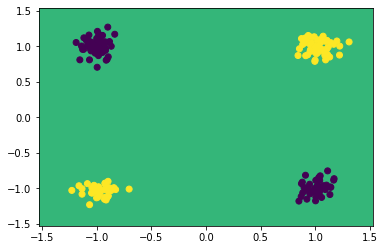

In [21]:
levels=jnp.linspace(-4., 2., 100)
norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
plt.pcolormesh(xv, yv, -y_pred[:,:,2], shading='nearest', norm=norm);
plt.scatter(Xor[:,0], Xor[:,1], c=yor)

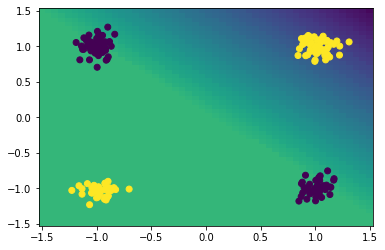

In [22]:
levels=jnp.linspace(-4., 2., 100)
norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
plt.pcolormesh(xv, yv, -y_pred[:,:,3], shading='nearest', norm=norm);
plt.scatter(Xor[:,0], Xor[:,1], c=yor)

## Neural networks losses

Classification

- Independent classes, binary crossentropy with sigmoid activation

- Exclusive classes, categorical crossentropy with softmax activation


\begin{align}
\sigma(x_i) &= \frac{e^{x_i}}{\sum_j e^{x_j}} \\
l(y, F(x))) &= - \sum_i y_i \log F(\mathbf{x})[i]
\end{align}




Regression

- Usual $\ell_2$, $\ell_1$ losses



# Neural networks capacity

Consider that a feed forward neural network is an acyclic directed graph $(V, E)$

Theorem: $\forall n$, there exists a graph $V, E$ of depth 2, such that $\mathcal{H}(V, E, \text{sign})$ contains all function from $\{\pm 1\}^n$ to $\{\pm 1\}$.  


   
\begin{align*}
~
\end{align*}




A neural network with a single hidden layer and the sign activation function can approximate any binary function over binary vectors




## Proof

- Consider a network with a single hidden layer of $2^n$ neurons

- Let $\{u_i\}_{1 \leq k \leq n}$ be the set of $k$ input vector that have label 1

- Remark that $\forall i, \langle u_i, u_i\rangle = n$ and $\forall x, \forall i, x \neq u_i \Leftrightarrow \langle x, u_i \rangle \leq n-2$ (minimum 1 bit difference)

- Set $k$ neurons to $h_i(x) = \text{sign}(u_i^\top x - n +1)$, we have $h_i(x) = 1$ iff $x = u_i$ and $-1$ else 

- Set the output to $$F(x) = \text{sign} (\sum_i h_i(x) +k - 1)$$

## Neural network capacity

Theorem (Cybenko 1989): $\forall n$, let $s(n)$ be the minimal integer such that there exist a graph $(V, E)$ with $\vert V \vert = n$ such that the hypothesis class $\mathcal{H}(V, E, \text{sign})$ contains all the function to $\{0, 1\}^n$ to $\{0, 1\}$. Then, $s(n)$ is exponential in $n$. Similar results hold for the sigmoid function. 

\begin{align*}
~
\end{align*}




1 hidden layer MLPs can approximate any function but require an exponential number of neurons.




## VC dimension

Theorem: The VC dimension of $\mathcal{H}(V, E, \text{sign})$ is $\mathcal{O}(|E|\log |E|)$ 

\begin{align*}
~
\end{align*}




The capacity of neural networks is more defined by their connectivity than by their number of neurons. Deeper networks have higher capacity.




## Effect of width

In [23]:
def train_nn(n):
    w1 = np.random.randn(2, n)/(jnp.sqrt(n))
    w2 = np.random.randn(n)/(jnp.sqrt(n))
    b1 = np.random.randn(n)/(jnp.sqrt(n))
    b2 = np.random.randn(1)/(jnp.sqrt(n))

    loss = []
    for t in range(1000):
        loss.append(xe(w1, w2, b1, b2, Xor, yor))
        w1, w2, b1, b2 = update(w1, w2, b1, b2, Xor, yor, eta=0.1)
    return loss

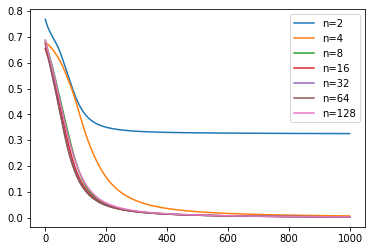

In [24]:
for n in range(1, 8):
    plt.plot(train_nn(2**n), label='n={}'.format(2**n))
plt.legend()

Larger NN, easier to train?

In [25]:
def train_nn2(n):
    w1 = np.random.randn(2, n)/(jnp.sqrt(n))
    w2 = np.random.randn(n)/(jnp.sqrt(n))
    b1 = np.random.randn(n)/(jnp.sqrt(n))
    b2 = np.random.randn(1)/(jnp.sqrt(n))

    w = w1
    w_change = []
    for t in range(1000):
        ind = np.random.choice(len(Xor), size=128, replace=False)
        w1, w2, b1, b2 = update(w1, w2, b1, b2, Xor[ind, :], yor[ind], eta=0.1)
        w_change.append(jnp.linalg.norm(w1 - w)/jnp.linalg.norm(w))
    return w_change

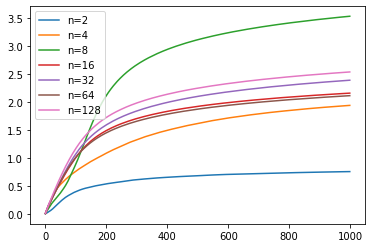

In [26]:
for n in range(1, 8):
    plt.plot(train_nn2(2**n), label='n={}'.format(2**n))
plt.legend()

Larger networks tend to change less than smaller networks?

## Neural Tangent Kernel

Consider the loss function as a function of $\mathbf{w}$ instead of $x$

$$ l_\mathbf{x}(\mathbf{w}) = l(y, F_\mathbf{w}(\mathbf{x})) $$

Approximate it using its Taylor expansion

$$l_\mathbf{x}(\mathbf{w}) \approx l_\mathbf{x}(\mathbf{w}_0) + \nabla l_\mathbf{x}(\mathbf{w}_0) ^\top (\mathbf{w} - \mathbf{w}_0) $$

Corresponds to a linear model with the non-linear mapping

$$ \phi(\mathbf{x}) = \nabla l_\mathbf{x}(\mathbf{w}_0) $$

Defining a kernel

This approximation tends to be better when the width grows


Some weights are highly influencial ( $| \sum_i \phi(\mathbf{x}_i)[j] | \gg 0$ )


Blind spots in the kernel ( $\sum_i \phi(\mathbf{x}_i)[j] \approx 0$ ) mean that some components are barely updated



Very large model are easier to train because only few neurons need to be changed to (over?)fit the training data

## Lottery ticket hypothesis


__The Lottery Ticket Hypothesis__ A randomly-initialized, dense neural network contains a subnet-work that is initialized such that—when trained in isolation—it can match the test accuracy of theoriginal network after training for at most the same number of iterations.






- Pruning a randomly initialized network can yield a good predictor (verified empirically).

- In practice, pruning is difficult, better train the full model.



## Double Descent

Do larger networks systematically overfit?

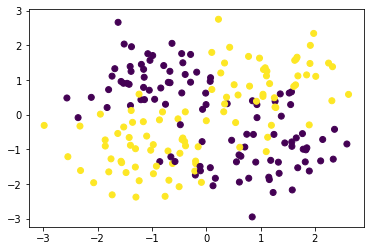

In [27]:
Xor_tr = jnp.sign(np.random.randn(200, 2))
yor_tr = 1.*((Xor_tr[:,0]*Xor_tr[:,1])>0)
Xor_tr += 0.7*np.random.randn(200,2)
Xor_te = jnp.sign(np.random.randn(200, 2))
yor_te = 1.*((Xor_te[:,0]*Xor_te[:,1])>0)
Xor_te += 0.7*np.random.randn(200,2)

plt.scatter(Xor_tr[:,0], Xor_tr[:,1], c=yor_tr)

In [28]:
n = 10000
w1 = np.random.randn(2, n)/(jnp.sqrt(n))
w2 = np.random.randn(n)/(jnp.sqrt(n))
b1 = np.random.randn(n)/(jnp.sqrt(n))
b2 = np.random.randn(1)/(jnp.sqrt(n))

loss = 0
for t in range(1000):
    loss = xe(w1, w2, b1, b2, Xor_te, yor_te)
    w1, w2, b1, b2 = update(w1, w2, b1, b2, Xor_tr, yor_tr, eta=0.1)

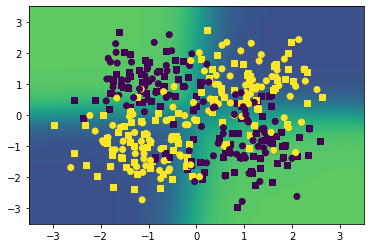

In [29]:
t = 50; tx = jnp.linspace(-3.5, 3.5, t)
xv, yv = jnp.meshgrid(tx, tx, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
xx = jnp.array([[xx, yy] for yy in yv for xx in xv])
y_pred = jnp.array(func(w1, w2, b1, b2, xx)).reshape(t, t)
cmap = plt.get_cmap('PiYG')
levels=jnp.linspace(-1.5, .5, 100)
norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
plt.pcolormesh(xv, yv, -y_pred, shading='gouraud', norm=norm);
plt.scatter(Xor_tr[:,0], Xor_tr[:,1], c=yor_tr, marker='s')
plt.scatter(Xor_te[:,0], Xor_te[:,1], c=yor_te)

Double descent phenomenon

<img src="modeldd.svg" width="800px" />

Overfitting solution exist, but are difficult to attain with SGD from well initialized network

# Neural Networks , take home

- Artificial neuron: linear combination with pointwise non-linearity
- Layer: stacked neurons
- MLP: Layer composition



Training

- Backpropagation: Automatic differenciation

- Stochastic gradient descent with mini-batch

- Vanishing/exploding gradient (saturating non-linearity)

- Non-convex optimization problem, but very effective in practice





Capacity

- Universal approximation theorem

- Capacity depending on connectivity (rather than size)




NTK


- Well initialized large networks tend to behave linearly during optimization

- Some neurons will not be updated

- $\exists$ a good subnetwork in the random initialization - Lottery ticket





Double Descent

- Extremely large models can avoid overfitting

- Double descent phenomenon (overfitting difficult to reach with SGD from good init)

